In [ ]:
!pip install torch torchvision matplotlib

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:34<00:00, 43.8MB/s]
100% 1.33G/1.33G [00:35<00:00, 40.7MB/s]


In [ ]:
!unzip celeba-dataset.zip -d ./data/

Streaming output truncated to the last 5000 lines.
  inflating: ./data/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: ./data/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: ./data/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: ./data/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: ./data/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: ./data/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: ./data/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: ./data/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: ./data/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: ./data/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: ./data/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: ./data/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: ./data/img_align_celeba/img_align_celeba/197617.jpg  
  inflating: ./data/img_align_celeba/img_align_celeba/197618.jpg  
  inflating

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

#Define your transformations
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

In [ ]:
dataset = ImageFolder(root='./data/img_align_celeba',transform=transform)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [ ]:
class Generator(nn.Module):

    def __init__(self):

        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.model(input) # Changed self.main to self.model
netG = Generator().to(device)


In [ ]:
class Discriminatpr(nn.Module):
  def __init__(self):
    super(Discriminatpr, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(3, 64, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(128,256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(256,512,4,2,1,bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(512,1,4,1,0,bias=False),
        nn.Sigmoid()
    )
  def forward(self, input):
    return self.main(input)

netD = Discriminatpr().to(device)

In [ ]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, 100, 1, 1, device=device)
real_label = 1
fake_label = 0

optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
num_epochs=5

for epoch in range(num_epochs):
  for i, data in enumerate(train_loader,0):
    netD.zero_grad()
    real_images=data[0].to(device)
    b_size=real_images.size(0)
    labels=torch.full((b_size,),real_label,device=device, dtype=torch.float) # Changed the data type to float
    output=netD(real_images).view(-1)
    lossD_real=criterion(output,labels)
    lossD_real.backward()

    noise=torch.randn(b_size,100,1,1,device=device)
    fake_images=netG(noise)
    labels.fill_(fake_label)
    output=netD(fake_images.detach()).view(-1)
    lossD_fake=criterion(output,labels)
    lossD_fake.backward()
    optimizerD.step()

    netG.zero_grad()
    labels.fill_(real_label)
    output=netD(fake_images).view(-1)
    lossG=criterion(output,labels)
    lossG.backward()

    optimizerG.step()

    if i % 100 == 0:
      print(f'Epoch [{epoch}/{num_epochs}] Step [{i}/{len(train_loader)}] ' f'Loss D: {lossD_real + lossD_fake} Loss G: {lossG}')

Epoch [0/5] Step [0/1267] Loss D: 1.3260329961776733 Loss G: 2.705026626586914
Epoch [0/5] Step [100/1267] Loss D: 0.4700201749801636 Loss G: 5.610800266265869
Epoch [0/5] Step [200/1267] Loss D: 0.7990068793296814 Loss G: 2.7346413135528564
Epoch [0/5] Step [300/1267] Loss D: 0.7046592831611633 Loss G: 2.461107015609741
Epoch [0/5] Step [400/1267] Loss D: 0.5211753249168396 Loss G: 2.3598971366882324
Epoch [0/5] Step [500/1267] Loss D: 0.5900577902793884 Loss G: 5.0112152099609375
Epoch [0/5] Step [600/1267] Loss D: 0.6894376873970032 Loss G: 2.263561725616455
Epoch [0/5] Step [700/1267] Loss D: 0.3091558814048767 Loss G: 4.802219390869141
Epoch [0/5] Step [800/1267] Loss D: 0.5770477652549744 Loss G: 2.2353568077087402
Epoch [0/5] Step [900/1267] Loss D: 0.8992540240287781 Loss G: 5.423172950744629
Epoch [0/5] Step [1000/1267] Loss D: 0.627440333366394 Loss G: 2.865812301635742
Epoch [0/5] Step [1100/1267] Loss D: 0.6476653814315796 Loss G: 4.845005035400391
Epoch [0/5] Step [1200/12

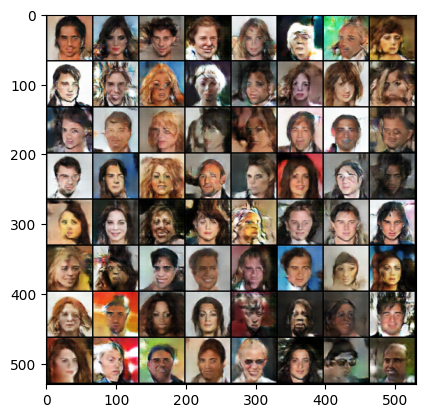

In [ ]:
with torch.no_grad():
  fake = netG(fixed_noise).detach().cpu()
  fake = (fake+1)/2.0 # replace to [0,1]
  grid = torchvision.utils.make_grid(fake, padding=2, normalize=True)

plt.imshow(np.transpose(grid, (1,2,0)))
plt.show()